In [1]:
import numpy as np
import cv2
from pathlib import Path
import tifffile as tiff
from matplotlib import pyplot as plt
from scipy.ndimage import rotate
import math
import SimpleITK as sitk
from scipy.optimize import minimize
from tqdm import tqdm
import sys
sys.path.append(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\10_code\UTvsXCT-preprocessing')
from preprocess_tools.register import YZ_XZ_inclination

In [2]:

# ---------- Rutas ----------
pr_num = 12
file_XCT = Path(fr'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\4\aligned_90rotright_reslicetop.tif')
file_UT = Path(fr'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Probetas JI\probetas\4\4_amplitude.tif')

volume_XCT = tiff.imread(file_XCT)
volume_UT = tiff.imread(file_UT)

In [3]:

# ---------- Ángulos ----------
angle_yz_ut, angle_xz_ut = YZ_XZ_inclination(volume_UT,'UT')

angle_yz_xct, angle_xz_xct = YZ_XZ_inclination(volume_XCT,'XCT')

print('[Ángulos originales]')
print(f'UT: YZ={angle_yz_ut:.2f}°, XZ={angle_xz_ut:.2f}°')
print(f'XCT: YZ={angle_yz_xct:.2f}°, XZ={angle_xz_xct:.2f}°')

Finding surface points: 100%|██████████| 4778583/4778583 [03:47<00:00, 21025.01it/s]


[Ángulos originales]
UT: YZ=2.85°, XZ=-1.87°
XCT: YZ=-0.01°, XZ=0.07°


[Ángulos originales]

UT: YZ=4.13°, XZ=-2.37°

XCT: YZ=0.30°, XZ=0.25°

In [4]:
rotation_angle_yz = angle_yz_xct - angle_yz_ut
rotation_angle_xz = angle_xz_xct - angle_xz_ut

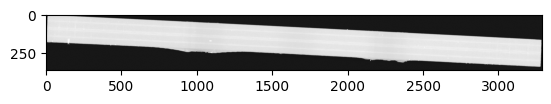

In [5]:
img = volume_XCT.max(axis=2)

rotated_img = rotate(img, angle=rotation_angle_yz, axes=(0, 1), reshape=True, cval = 40)

plt.imshow(rotated_img, cmap='gray')

In [6]:
def rotate_volume(volume, angle_yz, angle_xz):

    """
    Rotate a 3D volume based on estimated angles in the YZ and XZ planes.
    Parameters
    ----------
    volume : numpy.ndarray
        3D volume to be rotated, expected shape (Z, Y, X).
    angle_yz : float
        Angle in degrees to rotate around the X axis (YZ plane).
    angle_xz : float
        Angle in degrees to rotate around the Y axis (XZ plane).    
    Returns
    -------
    rotated_volume : numpy.ndarray
        Rotated 3D volume.
    """
    
    ###(Y,Z) plane rotation###

    #Step 1: Calculate the new shape after rotation in the YZ plane
    yz_new_shape = rotate(volume[:,:,0], angle=angle_yz, reshape=True, cval=40).shape

    #Step 2: Create an empty array with the new shape
    rotated_volume_yz = np.zeros((yz_new_shape[0], yz_new_shape[1], volume.shape[2]), dtype=volume.dtype)

    #Step 3: Rotate each slice in the XZ plane
    for i in tqdm(range(volume.shape[2]), desc="Rotating YZ slices"):
        rotated_volume_yz[:,:,i] = rotate(volume[:,:,i], angle=angle_yz, reshape=True, cval=40)

    ###(X,Z) plane rotation###

    #Step 1: Calculate the new shape after rotation in the XZ plane
    xz_new_shape = rotate(rotated_volume_yz[:,0,:], angle=angle_xz, reshape=True, cval=40).shape

    #Step 2: Create an empty array with the new shape
    rotated_volume_xz = np.zeros((xz_new_shape[0], rotated_volume_yz.shape[1], xz_new_shape[1]), dtype=volume.dtype)

    #Step 3: Rotate each slice in the YZ plane
    for i in tqdm(range(rotated_volume_yz.shape[1]), desc="Rotating XZ slices"):
        rotated_volume_xz[:,i,:] = rotate(rotated_volume_yz[:,i,:], angle=angle_xz, reshape=True, cval=40)

    return rotated_volume_xz

In [7]:
from joblib import Parallel, delayed

def rotate_volume(volume, angle_yz, angle_xz, n_jobs=-1):
    """
    Rotate a 3D volume based on estimated angles in the YZ and XZ planes, using parallel processing.
    
    Parameters
    ----------
    volume : numpy.ndarray
        3D volume to be rotated, expected shape (Z, Y, X).
    angle_yz : float
        Angle in degrees to rotate around the X axis (YZ plane).
    angle_xz : float
        Angle in degrees to rotate around the Y axis (XZ plane).
    n_jobs : int, default=-1
        Number of jobs for parallel processing. -1 means using all processors.
        
    Returns
    -------
    rotated_volume : numpy.ndarray
        Rotated 3D volume.
    """
    
    # Define helper function for YZ rotation
    def rotate_yz_slice(i, vol, angle):
        return rotate(vol[:,:,i], angle=angle, reshape=True, cval=40)
    
    # Define helper function for XZ rotation
    def rotate_xz_slice(i, vol, angle):
        return rotate(vol[:,i,:], angle=angle, reshape=True, cval=40)
    
    ###(Y,Z) plane rotation###

    if angle_yz != 0:
    
        #Step 1: Calculate the new shape after rotation in the YZ plane
        yz_new_shape = rotate(volume[:,:,0], angle=angle_yz, reshape=True, cval=40).shape
        
        #Step 2: Process all slices in parallel
        rotated_slices_yz = Parallel(n_jobs=n_jobs)(
            delayed(rotate_yz_slice)(i, volume, angle_yz) 
            for i in tqdm(range(volume.shape[2]), desc="Rotating YZ slices")
        )
        
        #Step 3: Construct the intermediate volume
        rotated_volume_yz = np.zeros((yz_new_shape[0], yz_new_shape[1], volume.shape[2]), dtype=volume.dtype)
        for i, rotated_slice in enumerate(rotated_slices_yz):
            rotated_volume_yz[:,:,i] = rotated_slice
    
    else:

        rotated_volume_yz = volume.copy()
    
    ###(X,Z) plane rotation###

    if angle_xz == 0:
        # If no rotation is needed in the XZ plane, return the YZ rotated volume
        return rotated_volume_yz
    
    #Step 1: Calculate the new shape after rotation in the XZ plane
    xz_new_shape = rotate(rotated_volume_yz[:,0,:], angle=angle_xz, reshape=True, cval=40).shape
    
    #Step 2: Process all slices in parallel
    rotated_slices_xz = Parallel(n_jobs=n_jobs)(
        delayed(rotate_xz_slice)(i, rotated_volume_yz, angle_xz) 
        for i in tqdm(range(rotated_volume_yz.shape[1]), desc="Rotating XZ slices")
    )
    
    #Step 3: Construct the final volume
    rotated_volume_xz = np.zeros((xz_new_shape[0], rotated_volume_yz.shape[1], xz_new_shape[1]), dtype=volume.dtype)
    for i, rotated_slice in enumerate(rotated_slices_xz):
        rotated_volume_xz[:,i,:] = rotated_slice
    
    return rotated_volume_xz

In [8]:
# Example usage
rotated_volume_XCT = rotate_volume(volume_XCT, angle_yz_xct, angle_xz_xct)

Rotating XZ slices: 100%|██████████| 3283/3283 [00:07<00:00, 463.79it/s]


(205, 3283, 1535)


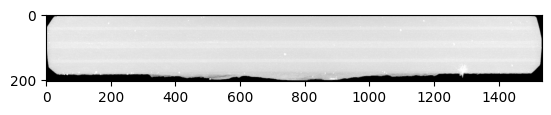

In [9]:
plt.imshow(rotated_volume_XCT.max(axis=1), cmap='gray')

print(rotated_volume_XCT.shape)

(203, 3283, 1535)


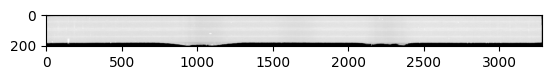

In [10]:
plt.imshow(rotated_volume_XCT.max(axis=2), cmap='gray')

print(volume_XCT.shape)

In [11]:

# ---------- Ángulos ----------
angle_yz_ut, angle_xz_ut = YZ_XZ_inclination(volume_UT,'UT')

angle_yz_xct, angle_xz_xct = YZ_XZ_inclination(rotated_volume_XCT,'XCT')

print('[Ángulos originales]')
print(f'UT: YZ={angle_yz_ut:.2f}°, XZ={angle_xz_ut:.2f}°')
print(f'XCT: YZ={angle_yz_xct:.2f}°, XZ={angle_xz_xct:.2f}°')

Finding surface points: 100%|██████████| 4778721/4778721 [03:38<00:00, 21846.04it/s]


[Ángulos originales]
UT: YZ=2.85°, XZ=-1.87°
XCT: YZ=0.01°, XZ=-0.00°


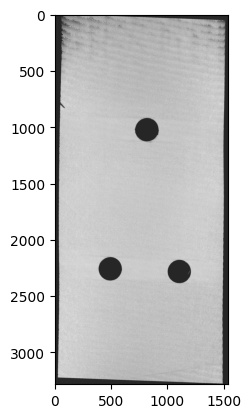

In [23]:
plt.imshow(volume_XCT[6, :, :], cmap='gray')